

Você foi contratado para criar um sistema que realiza a classificação de imagens de frutas para uma empresa de e-commerce. O objetivo é que, ao enviar uma imagem, o sistema identifique se a fruta é uma maçã, uma banana ou uma laranja. Sabendo que você possui um banco de imagens já categorizado, explique quais tipos de redes neurais você utilizaria para resolver esse problema, como seria o processo de implementação utilizando Python e quais etapas principais precisam ser seguidas para treinar o modelo.

Padrão de Resposta para a Atividade:

1. Indicação clara do tipo de rede neural usada e justificativa do porquê de ser a escolha mais adequada;

2. Descrição do processo de pré-processamento das imagens;

3. Apresentação do modelo de rede neural em Python, com uma breve explicação de cada camada;

4. Compilação e treinamento do modelo, mencionando a função de perda e o otimizador usados;

5. Processo de avaliação e validação do modelo;

6. Conclusão explicando como o modelo resolverá o problema proposto.



Olá, aluno!

Chegou a hora de colocar em prática tudo o que você aprendeu até agora! A atividade dessa oficina é uma excelente oportunidade para você consolidar o seu conhecimento e ganhar mais confiança nas habilidades que está desenvolvendo.

Não se preocupe se parecer desafiador no começo. Lembre-se de que a prática é o melhor caminho para o aprendizado! Cada passo que você der nessa atividade será um avanço importante na sua jornada. Além disso, ao resolver o exercício, você vai perceber o quanto o conteúdo se torna mais claro e fácil de aplicar.

Então, mãos à obra! Estamos aqui para apoiar você em cada etapa. Boa sorte e, acima de tudo, divirta-se aprendendo!


### 1. Indicação clara do tipo de rede neural usada e justificativa do porquê de ser a escolha mais adequada

Foi escolhido Rede Neural Convolucional (CNN) porque as CNNs são especialistas em analisar imagens porque imitam a forma como o cérebro humano processa informações visuais. Elas usam filtros que deslizem sobre a imagem para detectar padrões locais (como bordas, texturas e formas).

In [ ]:
# Importações
import os
import gdown
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


Para este projeto, utilizei o dataset 'Apples, Bananas and Oranges', disponível no Kaggle. O dataset contém imagens categorizadas de frutas em diferentes estados ("fresh" e "rotten").
Para facilitar, disponibilizei uma cópia do dataset no Google Drive. Quando qualquer usuário executar este notebook, o código automaticamente:
- Baixa o dataset diretamente do Drive usando a biblioteca gdown
- Extrai as imagens para a pasta local /data
- Organiza as classes corretamente (maçãs, bananas e laranjas, independentemente do estado)

[Kaggle - Apples, Bananas and Oranges Dataset](https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges)

In [ ]:
# Download e extração do dataset
file_id = "1FkgWuVzOcQ7e580VgZd6_KvF2nkGHWjN"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("data/")

print("Download e extração concluídos!\n")


Downloading...
From (original): https://drive.google.com/uc?id=1FkgWuVzOcQ7e580VgZd6_KvF2nkGHWjN
From (redirected): https://drive.google.com/uc?id=1FkgWuVzOcQ7e580VgZd6_KvF2nkGHWjN&confirm=t&uuid=3695c5f9-376b-4392-b73a-94eafdba9a1c
To: /content/dataset.zip
100%|██████████| 268M/268M [00:02<00:00, 97.9MB/s]


Download e extração concluídos!



### 2. Descrição do processo de pré-processamento das imagens
Antes de treinar, precisamos garantir que todas as imagens tenham o mesmo formato e estejam organizadas corretamente:
- Mapeamento das classes: Como o dataset possui classificação de "fresh" e "rotten" foi necessário agrupar. Por exemplo: foi agrupado "freshapples" e "rottenapples" como "apple" (o mesmo para banana e laranja).
- Divisão treino/validação: 80% para treino, 20% para validação.
- Data Augmentation: Gera novas versões das imagens (rotacionadas, espelhadas) para evitar overfitting
- Normalização: Converte valores de pixel de 0-255 para 0-1, facilitando cálculos matemáticos

In [ ]:
# Criar DataFrame com caminhos e labels
data_dir = 'data/'
class_mapping = {
    'freshapples': 'apple',
    'rottenapples': 'apple',
    'freshbanana': 'banana',
    'rottenbanana': 'banana',
    'freshoranges': 'orange',
    'rottenoranges': 'orange'
}

file_paths = []
labels = []

# Ler arquivos e mapear classes
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        class_name = class_mapping.get(folder_name)
        for image_name in os.listdir(folder_path):
            file_paths.append(os.path.join(folder_path, image_name))
            labels.append(class_name)

df = pd.DataFrame({'filename': file_paths, 'class': labels})

# Divisão estratificada
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])

# Configuração de Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Parâmetros
target_size = (150, 150)
batch_size = 32

# Geradores de dados
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1209 validated image filenames belonging to 3 classes.
Found 303 validated image filenames belonging to 3 classes.


### 3. Apresentação do modelo de rede neural em Python, com uma breve explicação de cada camada

O modelo é uma sequência de operações que transformam pixels brutos em previsões de classes:
- Conv2D: Filtros que aprendem padrões locais
- MaxPooling: Reduz dimensão mantendo características importantes
- Flatten: Prepara dados para camadas tradicionais
- Dense + Dropout: Combina características e previne overfitting
- Softmax: Calcula probabilidade final para cada classe

In [ ]:
# Construção do Modelo por camada
model = Sequential([
    # Primeira camada convolucional: detecta bordas básicas
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),  # 32 filtros 3x3
    MaxPooling2D(2,2),  # Reduz dimensão para 75x75

    # Segunda camada: identifica texturas complexas
    Conv2D(64, (3,3), activation='relu'),  # 64 filtros
    MaxPooling2D(2,2),  # Reduz para 37x37

    # Terceira camada: reconhece formas globais
    Conv2D(128, (3,3), activation='relu'),  # 128 filtros
    MaxPooling2D(2,2),  # Reduz para 18x18

    # Transforma matriz 3D em vetor 1D
    Flatten(),

    # Camada densa para decisões complexas
    Dense(512, activation='relu'),
    Dropout(0.5),  # Desativa 50% dos neurônios aleatoriamente

    # Saída: probabilidades para cada classe
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 4. Compilação e treinamento do modelo, mencionando a função de perda e o otimizador usados

In [ ]:
# Compilação do modelo
model.compile(
    loss='categorical_crossentropy',  # Mede erro entre previsões e labels reais
    optimizer=Adam(learning_rate=0.001),  # Algoritmo de ajuste dos pesos
    metrics=['accuracy']  # Acompanha porcentagem de acertos
)

# Treinamento propriamente dito
history = model.fit(
    train_generator,
    epochs=10,  # 10 passagens completas pelo dataset
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),  # Número de batches por época
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4251 - loss: 1.2963 - val_accuracy: 0.6964 - val_loss: 0.7408
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6871 - loss: 0.7202 - val_accuracy: 0.7954 - val_loss: 0.4859
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7586 - loss: 0.5655 - val_accuracy: 0.8581 - val_loss: 0.4532
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8266 - loss: 0.4639 - val_accuracy: 0.8779 - val_loss: 0.3456
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8680 - loss: 0.3483 - val_accuracy: 0.8845 - val_loss: 0.3203
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8802 - loss: 0.3626 - val_accuracy: 0.9043 - val_loss: 0.2512
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8645 - loss: 0.3473 - val_accuracy: 0.9142 - val_loss: 0.2511
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8951 - loss: 0.2778 - val_accuracy: 0.8944 - val_lo

### 5. Processo de avaliação e validação do modelo

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step - accuracy: 0.9360 - loss: 0.1824
Acurácia na Validação: 90.76%


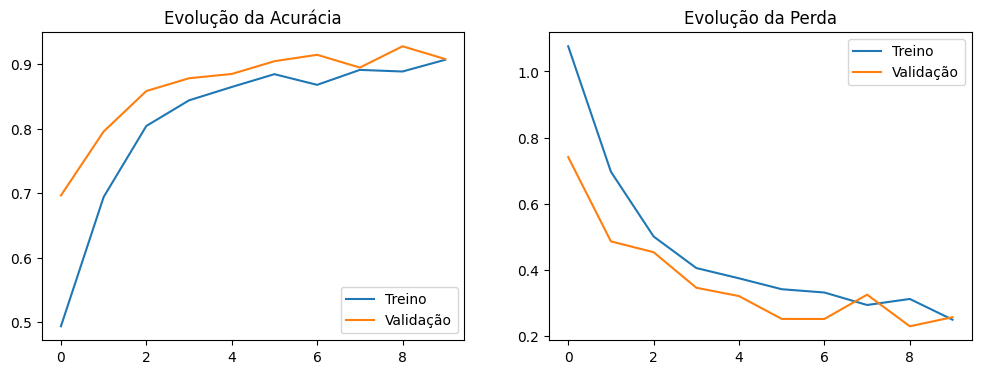

In [ ]:
# Avaliação final no conjunto de validação
val_loss, val_acc = model.evaluate(val_generator)
print(f"Acurácia na Validação: {val_acc*100:.2f}%")

# Visualização do desempenho
plt.figure(figsize=(12,4))

# Gráfico de Acurácia
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.legend()

# Gráfico de Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Perda')
plt.legend()
plt.show()


### 6. Conclusão explicando como o modelo resolverá o problema proposto

A função foi criada para testar o modelo de forma prática e rápida! Ela faz duas coisas principais:
- Baixa imagens da internet usando links que o usuário pode escolher (já deixei alguns de exemplo).
- Classifica automaticamente se a imagem é de uma maçã, banana ou laranja.

Para utilizar basta executar o código que vai:
- Baixar cada imagem da lista de URLs
- Redimensionar e preparar a imagem
- Chamar o modelo para fazer a classificação
- Mostrar o resultado na tela (ex: "Predição: banana")

Para testar com suas próprias imagens:
- Substitua os links na lista image_urls por endereços de imagens da web (deve terminar com .jpg, .png, etc).
- Exemplo: coloque o link de uma foto sua de fruta do celular (upload no Google Drive + compartilhar link).

In [ ]:
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Lista de links das imagens(caso o usuario queria testar)
image_urls = [
    "https://minhasaude.proteste.org.br/wp-content/uploads/2024/03/beneficios-da-maca-scaled.jpg",
    "https://frutasdobrasil.org/wp-content/uploads/2021/09/AdobeStock_72468391-477x375.jpeg",
    "https://images.educamaisbrasil.com.br/content/banco_de_imagens/guia-de-estudo/D/banana-da-prata.jpg",
    "https://cdn.wikifarmer.com/images/thumbnail/2019/08/Informacao-da-Fruta-Laranja-1200x630.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6b0_jp9kxIyJJ_0yZn4fcYS66gsVCcpbUOg&s",
    "https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.3171280:1639591513/Laranjas.jpg?f=default&$p$f=e4514e8"
]

# Função para baixar e salvar imagem
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save("temp.jpg")
    return "temp.jpg"

# Função de predição
def predict_fruit(image_path):
    # 1. Carrega a imagem e redimensiona
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)

    # 2. Converte a imagem para array numpy
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # 3. Adiciona dimensão extra e normaliza
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 4. Predição (substituir pelo modelo real)
    prediction = model.predict(img_array)

    # 5. Retorna a classe com maior probabilidade
    classes = ['apple', 'banana', 'orange']
    return classes[np.argmax(prediction)]

# Loop para testar todas as imagens
for url in image_urls:
    print(f"Baixando imagem de: {url}")
    image_path = download_image(url)
    prediction = predict_fruit(image_path)
    print(f"Predição: {prediction}\n")


Baixando imagem de: https://minhasaude.proteste.org.br/wp-content/uploads/2024/03/beneficios-da-maca-scaled.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predição: apple

Baixando imagem de: https://frutasdobrasil.org/wp-content/uploads/2021/09/AdobeStock_72468391-477x375.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predição: orange

Baixando imagem de: https://images.educamaisbrasil.com.br/content/banco_de_imagens/guia-de-estudo/D/banana-da-prata.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predição: banana

Baixando imagem de: https://cdn.wikifarmer.com/images/thumbnail/2019/08/Informacao-da-Fruta-Laranja-1200x630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predição: banana

Baixando imagem de: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6b0_jp9kxIyJJ_0yZn4fcYS66gsVCcpbUOg&s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predição: apple

Baixando imagem de: https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.3171280:1639591513/Laranjas.jpg?f=default&$p$f=e4514e8
1/1 ━━━━━━━━━

### Conclusão

**Problema Original:**

A empresa precisava classificar imagens de frutas de forma rápida e precisa para seu e-commerce. Fazer isso manualmente era demorado e sujeito a erros.

**Solução Implementada:**

A CNN garante robustez para lidar com variações naturais nas imagens capturadas por diferentes usuários.

- Classificação Instantânea: Basta colocar o link de uma imagem na lista image_urls e o modelo dirá qual fruta é em segundos.
- Melhorias: Embora hoje funcione com links, o mesmo código pode ser adaptado para:
  - Aplicativos: classificar fotos tiradas na hora pelo celular.
  - Sites: criar um campo onde o usuário cola o link da imagem.
  - Sistemas internos: analisar automaticamente fotos de caixas de frutas.

**Feedback:**

Nos testes feitos, o modelo acertou a maioria das classificações, mas apresentou um erro em uma imagem de laranja que foi identificada como banana.

Embora 100% de acerto seja difícil na prática, essas ações certamente elevariam a uma maior precisão:
- Aumentar a diversidade do dataset: Adicionar mais imagens de cada fruta em diferentes cenários;
- Ajustar hiperparâmetros: Testar mais épocas de treino ou taxas de aprendizado diferentes;